In [1]:
# Math and data
import numpy as np
import pandas as pd
import polars as pl
import math
# Neural network frameworks
import torch as th
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, RobertaTokenizer
# Utilities
import re
from enum import Enum
import contractions as ct
import utility as util
import json
import random
import os
from torch.utils.tensorboard import SummaryWriter
# Plotting
import matplotlib.pyplot as plt

# use seaborn style for matplotlib
plt.style.use("seaborn")

# Pytorch device
device = th.device("mps") if th.backends.mps.is_available() else th.device("cuda") if th.cuda.is_available() else th.device("cpu")
if device.type == "cuda":
    print(th.cuda.get_device_name(device))
else:
    print(device)

# device = th.device("cpu")

fig_dir = "img/"

NVIDIA GeForce RTX 2070 SUPER


Original len: 2875917
Pruned len: 462601


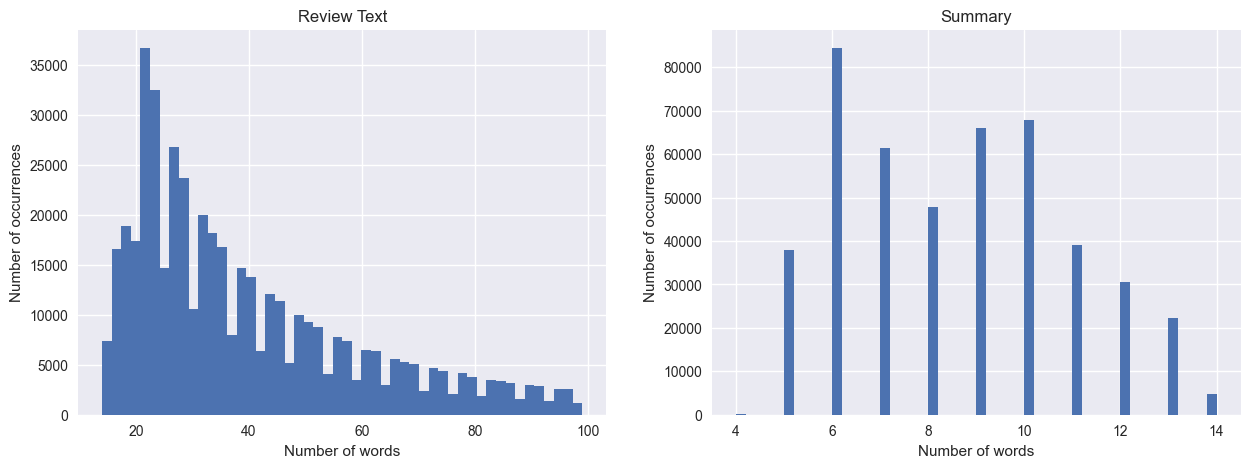

In [2]:
# Use simple GPT2 tokenizer for counting tokens
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Load dataset -> Prune dataset -> Tokenize dataset
df = util.load_dataset(util.Paths.arts, util.DatasetType.ORIGINAL)
print(f"Original len: {len(df)}")
df_pruned = util.prune(df)
print(f"Pruned len: {len(df_pruned)}")
util.save_dataset(df_pruned, util.Paths.arts, util.DatasetType.PRUNED)

# plot the review and summary word count distribution
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

text_word_count = df_pruned['reviewText'].apply(lambda x: len(x.split()))
summary_word_count = df_pruned['summary'].apply(lambda x: len(x.split()))

for ax, data, title in zip(ax.flatten(), [text_word_count, summary_word_count], ['Review Text', 'Summary']):
    ax.hist(data, bins=50)
    ax.set_title(title)
    ax.set_xlabel('Number of words')
    ax.set_ylabel('Number of occurrences')

plt.show()

# save figure as png and pdf
fig.savefig(fig_dir + "review_summary_word_count_distribution.png", dpi=300)
fig.savefig(fig_dir + "review_summary_word_count_distribution.pdf")

df_tokenized = util.tokenize(df_pruned, tokenizer)
print(f"Tokenized len: {len(df_tokenized)}")

# Find max token length of review text with numpy
max_review_len = np.max(list(df_tokenized['reviewText'].arr.lengths()))
print("\nMax token length of review text: ", max_review_len)
# Find max token length of summary with numpy
max_summary_len = np.max((list(df_tokenized['summary'].arr.lengths())))
print("Max token length of summary: ", max_summary_len)

In [6]:
# torch dataset from pandas dataframe
# defines a voacbulary of words and converts the review text to a list of indices
# beware of symbols like ., !, ? etc.
# pad the review text and summary to max_review_len and max_summary_len respectively

"""
ReviewDataset pytorch dataset interface
- expects a polars dataframe with columns reviewText, summary, overall
- expects it in the DatasetType.PRUNED format
- expects a GPT2Tokenizer
"""
class ReviewDataset(Dataset):
    def __init__(self, path: str, tokenizer: GPT2Tokenizer, length = None, dataset_type = util.DatasetType.PRUNED, device = "cpu"):
        self.df = util.load_dataset(path, dataset_type)
        if length is not None:
            # clip the dataset to length
            length = min(length, len(self.df))
            self.df = self.df.sample(length, shuffle=True)
        self.dataset_type = dataset_type

        match path:
            case util.Paths.arts:
                self.max_review_len = util.MaxTokenLength.ARTS_REVIEW
                self.max_summary_len = util.MaxTokenLength.ARTS_SUMMARY
            case util.Paths.video:
                self.max_review_len = util.MaxTokenLength.VIDEO_REVIEW
                self.max_summary_len = util.MaxTokenLength.VIDEO_SUMMARY
            case util.Paths.gift:
                self.max_review_len = util.MaxTokenLength.GIFT_REVIEW
                self.max_summary_len = util.MaxTokenLength.GIFT_SUMMARY
            case _:
                raise ValueError("Invalid path")
        
        self.tokenizer = tokenizer
        self.device = device

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        review = self.df["reviewText"][idx]
        summary = self.df["summary"][idx]
        rating = th.tensor(self.df["overall"][idx])

        # Tokenize the review and summary strings
        review = self.tokenizer.encode(review, add_special_tokens = True, padding = "max_length", truncation = True, max_length=self.max_review_len, return_tensors = "pt").squeeze()
        summary = self.tokenizer.encode(summary, add_special_tokens = True, padding = "max_length", truncation = True, max_length=self.max_summary_len, return_tensors = "pt").squeeze()

        # Move tensors to device
        review = review.to(self.device)
        summary = summary.to(self.device)
        rating = rating.to(self.device)
        
        return review, summary, rating
    
    def detokenize(self, x: th.Tensor):
        # # Remove everything after the first <eos> token
        # # This is important due to the fact that that output token is initialised with zeros
        # is_eos = (x == self.tokenizer.eos_token_id).long()
        # if is_eos.any():
        #     x = x[:is_eos.argmax().item()]

        return self.tokenizer.decode(x, skip_special_tokens=True, clean_up_tokenization_spaces=True)

    def batch_detokenize(self, x: th.Tensor):
        return [self.detokenize(x[i]) for i in range(len(x))]

In [11]:
# Test the dataset
# Setup
t = GPT2Tokenizer.from_pretrained("gpt2", add_bos_token=True, add_prefix_space=False, trim_offsets=True)
t.pad_token = t.eos_token
t.add_special_tokens({"bos_token": util.BOS_token})

# Create the dataset
dataset = ReviewDataset(util.Paths.arts, t, device=device)

data_idx = 45

# decode
print(f"Review: {ReviewDataset.detokenize(dataset, dataset[data_idx][0])}")
print(f"Summary: {ReviewDataset.detokenize(dataset, dataset[data_idx][1])}")
print(f"Rating: {int(dataset[data_idx][2])}")

# max length is the max index of the vocabulary
MAX_LENGTH = len(t)
print(f"MAX_LENGTH: {MAX_LENGTH}")

Review: i have purchased donna s other book on polymer which is excellent and this book is also in e same top quality directions are very clear with sharp images of steps for completion of projects  many design ideas and steps are provided  it is an excellent resource and source of inspiration  i would highly recommend this 
Summary: excellent resource for surface design with polymer clay
Rating: 1
MAX_LENGTH: 50258


In [ ]:
"""
Model
"""

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return th.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = nn.functional.softmax(
            self.attn(th.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = th.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = th.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = nn.functional.relu(output)
        output, hidden = self.gru(output, hidden)

        output = nn.functional.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return th.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
# Test the model with a single forward pass
""" hidden_size = 256
encoder = EncoderRNN(MAX_LENGTH, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, MAX_LENGTH, dropout_p=0.1).to(device)

# dl = DataLoader(dataset)
# dl_it = iter(dl)

# Take input from the dataset
input_tensor, target_tensor, rating_tensor = dataset[data_idx]
# print(input_tensor.get_device())

# Create the encoder hidden state
encoder_hidden = encoder.initHidden()

# Initialise the encoder output
encoder_outputs = th.zeros(MAX_LENGTH, encoder.hidden_size, device=device)

# Run the encoder
for token in input_tensor:
    # print(token)
    encoder_output, encoder_hidden = encoder(token, encoder_hidden)
    encoder_outputs[token] = encoder_output[0, 0]

bos = th.tensor(t.bos_token_id).to(device)

# Create the decoder input
decoder_input = th.tensor([bos], device=device, dtype=th.long)
# Create the decoder output
decoder_output_sequence = th.zeros(max_summary_len, device=device, dtype=th.long)

# Create the decoder hidden state
decoder_hidden = encoder_hidden

# Run the decoder
for i, target in enumerate(target_tensor):
    decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
    topv, topi = decoder_output.topk(1)
    decoder_input = topi.squeeze().detach() # detach from history as input
    
    # Append the output
    decoder_output_sequence[i] = decoder_input

    if decoder_input.item() == t.eos_token_id:
        print(f"EOS token found at {i}th iteration")
        break

# Print the output before detokenization
print(f"Output:\n{decoder_output_sequence}\n")

# Print the detokenized output
print(f"Detokenized output:\n{ReviewDataset.detokenize(dataset, decoder_output_sequence)}\n") """

' hidden_size = 256\nencoder = EncoderRNN(MAX_LENGTH, hidden_size).to(device)\ndecoder = AttnDecoderRNN(hidden_size, MAX_LENGTH, dropout_p=0.1).to(device)\n\n# dl = DataLoader(dataset)\n# dl_it = iter(dl)\n\n# Take input from the dataset\ninput_tensor, target_tensor, rating_tensor = dataset[data_idx]\n# print(input_tensor.get_device())\n\n# Create the encoder hidden state\nencoder_hidden = encoder.initHidden()\n\n# Initialise the encoder output\nencoder_outputs = th.zeros(MAX_LENGTH, encoder.hidden_size, device=device)\n\n# Run the encoder\nfor token in input_tensor:\n    # print(token)\n    encoder_output, encoder_hidden = encoder(token, encoder_hidden)\n    encoder_outputs[token] = encoder_output[0, 0]\n\nbos = th.tensor(t.bos_token_id).to(device)\n\n# Create the decoder input\ndecoder_input = th.tensor([bos], device=device, dtype=th.long)\n# Create the decoder output\ndecoder_output_sequence = th.zeros(max_summary_len, device=device, dtype=th.long)\n\n# Create the decoder hidden sta

In [ ]:
""" 
Training
"""
debugging = True # For debugging prints

n_epochs = 10
batch_size = 32
learning_rate = 0.0005
teacher_forcing_ratio = 0.5
hidden_size = 2**8

#-----------------------------------------------------------------------------------------------------------------------------------

run_dir = util.get_run_dir()
# add run info to the directory
run_dir += f"_batch-size_{batch_size}_learning-rate_{learning_rate}_teacher-forcing-ratio_{teacher_forcing_ratio}_hidden-size_{hidden_size}"
print(f"Current run_dir: {run_dir}")
# Readying the writer
writer = SummaryWriter(run_dir)

#-----------------------------------------------------------------------------------------------------------------------------------

# criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # TODO: Check without the ignore_index
criterion = nn.CrossEntropyLoss() # TODO: Check without the ignore_index
#criterion = nn.NLLLoss()

encoder = EncoderRNN(MAX_LENGTH, hidden_size).to(device).train()
decoder = AttnDecoderRNN(hidden_size, MAX_LENGTH, dropout_p=0).to(device).train()

encoder_optimizer = th.optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = th.optim.Adam(decoder.parameters(), lr=learning_rate)

#-----------------------------------------------------------------------------------------------------------------------------------

# Instantiate tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2", add_bos_token=True, add_prefix_space=True, trim_offsets=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_special_tokens({"bos_token": util.BOS_token})

# Create the dataset
dataset = ReviewDataset(util.Paths.arts, tokenizer, length=800, device=device)

# Calculate the number of elements in each bucket
split_ratios = [0.7, 0.2, 0.1]

# Get the data loaders
train_loader, val_loader, test_loader = util.get_data_loaders(dataset, batch_size, split_ratios)

#-----------------------------------------------------------------------------------------------------------------------------------


# Training loop
def train(learning_rate, n_epochs, train_loader, valid_loader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    for epoch in range(n_epochs):
        for batch_idx, (train_review_batch, train_summary_batch, train_rating_batch) in enumerate(train_loader):
            batch_loss = 0
            words_in_batch = 0

            # We calcualte the loss and backpropagate every batch
            # Reset the gradients
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            for review, summary, rating in zip(train_review_batch, train_summary_batch, train_rating_batch):
                # Create the encoder hidden state
                encoder_hidden = encoder.initHidden() # Can be understood as the context vector

                # Initialise the encoder output's "feature space"
                encoder_outputs = th.zeros(MAX_LENGTH, encoder.hidden_size, device=device)

                # Run the encoder
                for token in review:
                    encoder_output, encoder_hidden = encoder(token, encoder_hidden)
                    encoder_outputs[token] = encoder_output[0, 0]
                
                bos = th.tensor(t.bos_token_id).to(device)

                # Create the decoder input, the beginning of the sequence, starting with the BOS (Beginning Of String) token
                decoder_input = th.tensor([bos], device=device, dtype=th.long)

                # Initialize the decoder output
                decoder_output_sequence = th.empty(dataset.max_summary_len, device=device, dtype=th.float).fill_(t.pad_token_id)

                # Propagate the decoder hidden state
                decoder_hidden = encoder_hidden

                use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

                if use_teacher_forcing:
                    if debugging:
                        util.print_mod(f"USING TEACHER FORCING", [util.Modifiers.Colors.GREEN])
                    
                    # Teacher forcing: Feed the target as the next input
                    for target_index, target in enumerate(summary):
                        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
                        topv, topi = decoder_output.topk(1)
                        decoder_input = target # Teacher forcing

                        # Append the output
                        decoder_output_sequence[target_index] = topi.squeeze().detach() # detach from history as input

                        words_in_batch += 1
                        # Calculate the loss
                        batch_loss += criterion(decoder_output.squeeze(), target)

                        if decoder_input.item() == t.eos_token_id:
                            print(f"EOS token found at iteration {target_index}")
                            break
                else:
                    if debugging:
                        util.print_mod(f"NOT USING TEACHER FORCING", [util.Modifiers.Colors.RED])
                    
                    # Run the decoder
                    for target_index, target in enumerate(summary):
                        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
                        topv, topi = decoder_output.topk(1)
                        decoder_input = topi.squeeze().detach() # detach from history as input
                        
                        # Append the output
                        decoder_output_sequence[target_index] = decoder_input

                        words_in_batch += 1
                        # Calculate the loss
                        batch_loss += criterion(decoder_output.squeeze(), target)

                        if decoder_input.item() == t.eos_token_id:
                            print(f"EOS token found at iteration {target_index}")
                            break

                
                if debugging:
                    # print tokenized output
                    util.print_mod("Target tokenized:", [util.Modifiers.Styles.BOLD, util.Modifiers.Styles.ITALIC])
                    print(summary.tolist())
                    util.print_mod("Target Sequence:", [util.Modifiers.Styles.BOLD, util.Modifiers.Styles.ITALIC])
                    print(dataset.detokenize(summary))

                    # print tokenized output
                    util.print_mod("Tokenized output:", [util.Modifiers.Styles.BOLD, util.Modifiers.Styles.ITALIC])
                    print(decoder_output_sequence.tolist())
                    util.print_mod("Detokenized output:", [util.Modifiers.Styles.BOLD, util.Modifiers.Styles.ITALIC])
                    print(f"{dataset.detokenize(decoder_output_sequence)}\n")
            
            # Normalize the loss
            batch_loss /= words_in_batch
            # Backpropagate the loss
            batch_loss.backward()

            # Update the weights
            encoder_optimizer.step()
            decoder_optimizer.step()

            # Print the loss
            writer.add_scalar("Loss/train", batch_loss, epoch * len(train_loader) + batch_idx)
            # print(f"Epoch: {epoch}, Batch: {batch_idx}, Loss: {batch_loss}")
            util.print_mod(f"Epoch: {epoch}, Batch: {batch_idx}, Loss: {batch_loss}", [util.Modifiers.Colors.BLUE, util.Modifiers.Styles.BOLD])

train(learning_rate, n_epochs, train_loader, val_loader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

Current run_dir: runs/003_batch-size_16_learning-rate_0.005_teacher-forcing-ratio_0.5_hidden-size_256
NOT USING TEACHER FORCING
Target tokenized:
[50256, 475, 991, 1107, 3621, 284, 1394, 8389, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]
Target Sequence:
 but still really nice to keep organized
Tokenized output:
[35465.0, 24203.0, 37635.0, 5544.0, 19182.0, 15761.0, 23086.0, 14856.0, 14856.0, 780.0, 19182.0, 15761.0, 30189.0, 29332.0, 721.0, 28154.0, 47412.0, 38730.0, 27063.0, 5544.0, 30176.0, 9503.0, 36664.0, 30888.0, 30888.0, 19813.0, 11751.0, 9200.0, 37067.0, 14856.0, 14856.0, 34859.0, 14856.0, 5351.0, 19182.0, 29903.0, 24916.0]
Detokenized output:
young meltingfocus fourthArray 1945 prosecuted ul ul becauseArray 1945asonictouchec YORK BarronHK Finding fourthsensitivecomm composeninenine crushrer nic diagrams ul ul harms ul bonA

In [ ]:
""" # Test the model
def test(test_loader, encoder, decoder):
    for batch_idx, (test_review_batch, test_summary_batch, test_rating_batch) in enumerate(test_loader):
        for review, summary, rating in zip(test_review_batch, test_summary_batch, test_rating_batch):
            # Create the encoder hidden state
            encoder_hidden = encoder.initHidden() # Can be understood as the context vector

            # Initialise the encoder output's "feature space"
            encoder_outputs = th.zeros(MAX_LENGTH, encoder.hidden_size, device=device)

            # Run the encoder
            for token in review:
                encoder_output, encoder_hidden = encoder(token, encoder_hidden)
                encoder_outputs[token] = encoder_output[0, 0]

            # Create the decoder input, the beginning of the sequence, starting with the BOS (Beginning Of String) token
            decoder_input = th.tensor([bos], device=device, dtype=th.long)

            # Create the decoder output
            decoder_output_sequence = th.zeros(max_summary_len, device=device, dtype=th.float)

            # Propagate the decoder hidden state
            decoder_hidden = encoder_hidden

            # Run the decoder
            for target_index, target in enumerate(summary):
                decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach() # detach from history as input
                
                # Append the output
                decoder_output_sequence[target_index] = decoder_input

                if decoder_input.item() == t.eos_token_id:
                    print(f"EOS token found at {target_index}th iteration")
                    break

            # Print the output before detokenization
            print(f"Output:\n{decoder_output_sequence}\n")

            # Print the detokenized output
            print(f"Detokenized output:\n{ReviewDataset.detokenize(dataset, decoder_output_sequence)}\n")

test(test_loader, encoder, decoder) """